<a href="https://githubtocolab.com/borislevant/cvplayground/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import data, segmentation, color
from skimage.filters import gaussian, threshold_otsu


Cloning into 'images'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 68 (delta 20), reused 0 (delta 0), pack-reused 23
Unpacking objects: 100% (68/68), done.


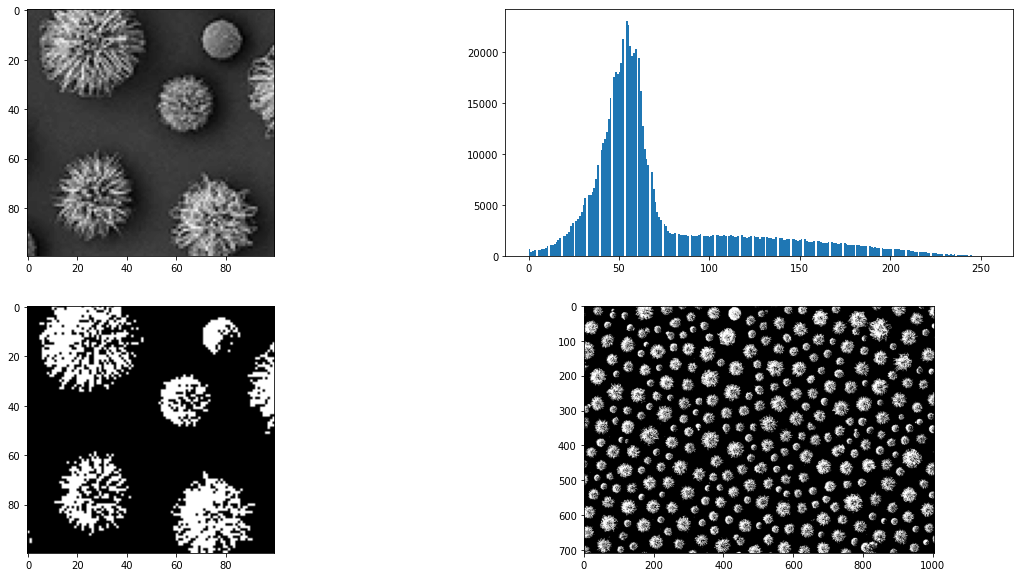

In [2]:
!git clone https://github.com/borislevant/documentscan/ images
img = cv2.imread(r'images/imgs/cryptococcus_big.tif', cv2.IMREAD_GRAYSCALE)
p1 = 100
p2 = 200
nbins = 256

t1 = threshold_otsu(img, nbins=nbins)
img_th = img.copy()
img_th[img_th <= t1] = 0
img_th[img_th > t1] = 255
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0, 0].imshow(img[p1:p2, p1:p2], cmap='gray')
ax[0, 1].hist(img.flatten(), bins=nbins)
ax[1, 0].imshow(img_th[p1:p2, p1:p2], cmap='gray')
ax[1, 1].imshow(img_th, cmap='gray')
plt.show()

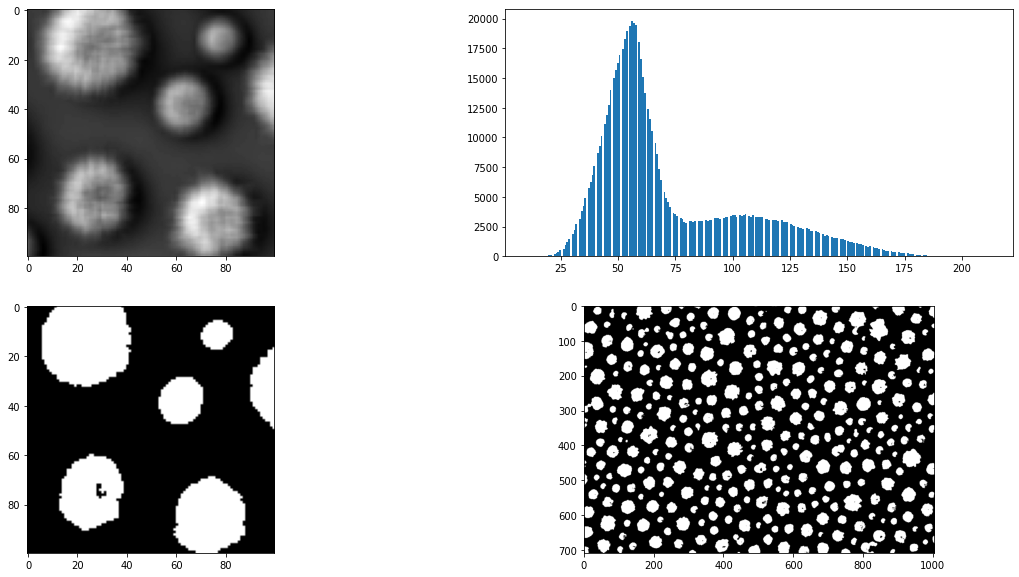

In [3]:
#blurred_image = gaussian(img, sigma=2)
ksize = 7
kernel = np.ones((ksize, ksize),np.float32)/ksize/ksize
blurred_image = cv2.filter2D(img, -1, kernel)

t2 = threshold_otsu(blurred_image, nbins=nbins)
ret, img_th2 = cv2.threshold(blurred_image, t2, 255, cv2.THRESH_BINARY) 
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0, 0].imshow(blurred_image[p1:p2, p1:p2], cmap='gray')
ax[0, 1].hist(blurred_image.flatten(), bins=nbins)
ax[1, 0].imshow(img_th2[p1:p2, p1:p2], cmap='gray')
ax[1, 1].imshow(img_th2, cmap='gray')
plt.show()


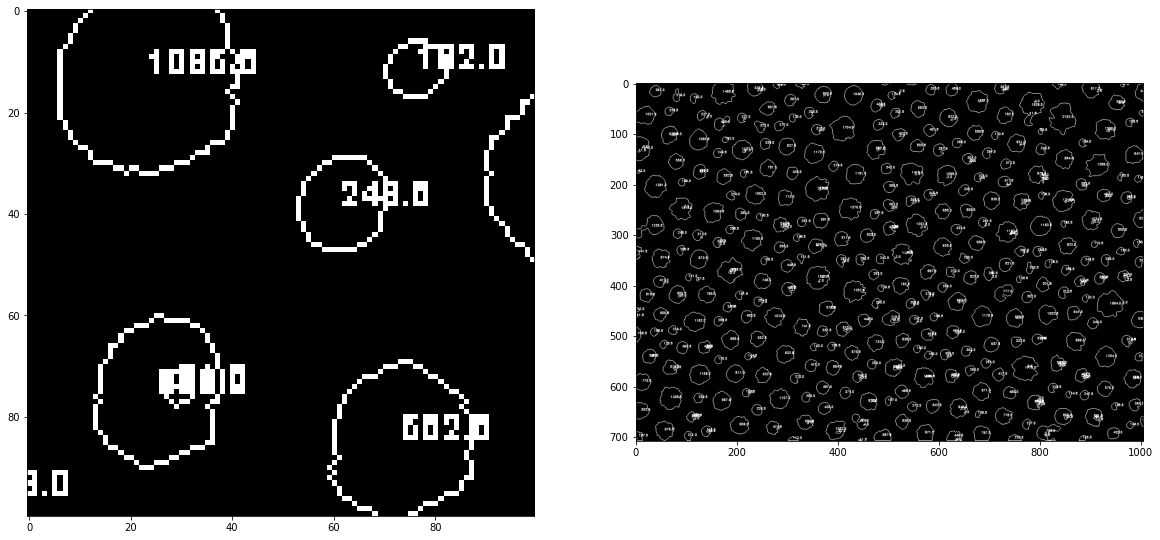

In [4]:
# find the contours from the thresholded image
contours, hierarchy = cv2.findContours(img_th2, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# draw all contours
img_blank = np.zeros(img_th2.shape)
image = cv2.drawContours(img_blank, contours, -1, (255, 255, 255), 1)
for c in contours:
    M = cv2.moments(c)
    area = cv2.contourArea(c)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0
    cv2.putText(image, "{}".format(area), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (255, 255, 255))

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image[p1:p2, p1:p2], cmap='gray')
ax[1].imshow(image, cmap='gray')




### K-Means Clustering

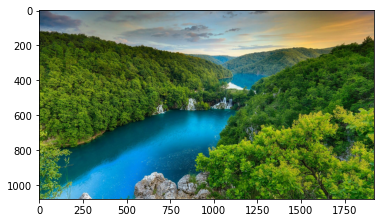

In [5]:
image = cv2.imread('images/imgs/river_trees.jpg', cv2.COLOR_BGR2RGB)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


In [6]:
# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = image.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)

In [7]:
# define stopping criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

# number of clusters (K)
k = 3
compactness, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

In [8]:
centers[labels].shape

(2073600, 3)

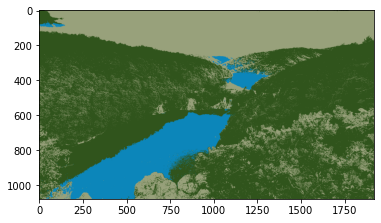

In [9]:
# convert all pixels to the color of the centroids
segmented_image = centers[labels]

# reshape back to the original image dimension
segmented_image = segmented_image.reshape(image.shape)

# show the image
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.show()

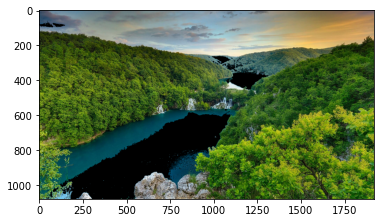

In [10]:
# disable only the cluster number 2 (turn the pixel into black)
masked_image = np.copy(image)
# convert to the shape of a vector of pixel values
masked_image = masked_image.reshape((-1, 3))
# color (i.e cluster) to disable
cluster = 2
masked_image[labels == cluster] = [0, 0, 0]

# convert back to original shape
masked_image = masked_image.reshape(image.shape)
# show the image
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.show()

### Felzenszwalb Algorithm

Number of segments 65


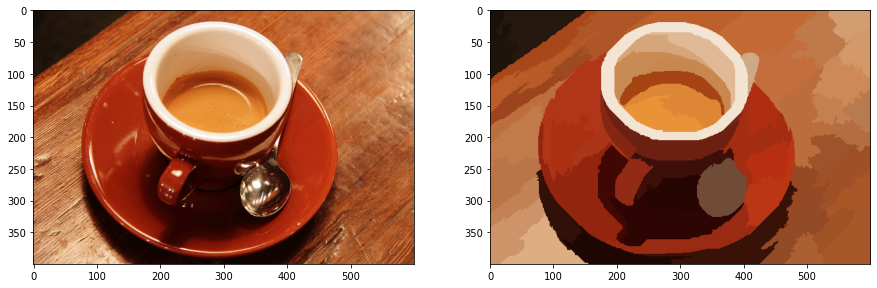

In [36]:
from skimage.segmentation import felzenszwalb
from skimage.data import coffee

img = coffee()
segments = felzenszwalb(img, scale=1.0, sigma=0.95, min_size=700)

def get_segmentation(img, seg):
  imgs = img.copy()
  segs = np.unique(segments.reshape((-1,)))
  for s in segs:
    imgs[seg==s, :] = np.mean(imgs[seg==s, :], axis=0)
  return imgs

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(img)
ax[1].imshow(get_segmentation(img, segments))

print('Number of segments {}'.format(len(np.unique(segments.reshape((-1,))))))
